## N = 18

True
{102: 1831, -1: 3628, 98: 3684, 100: 3617, 1: 3616, 97: 1843, 99: 3570, 101: 3584, 0: 7099, -2: 1797, 2: 1731}


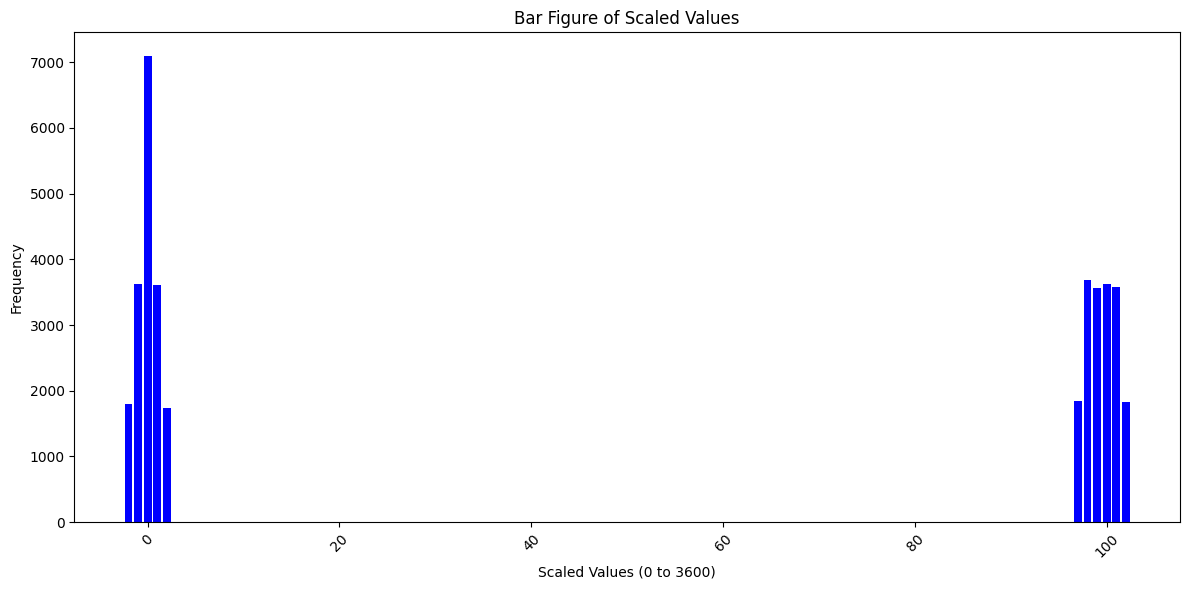

[ 0.         -0.04314788  1.          0.01437128  1.         -0.01567233
  1.          0.02240622  0.          0.08405648  1.         -0.10412931
  0.          0.09519215  1.         -0.00840616  1.          0.08814585
  0.         -0.02203794  1.          0.07955086  1.         -0.01643586
  0.         -0.00981669  1.          0.02983427  0.          0.17022502
  1.         -0.10444427  1.          0.08940268  0.          0.00506708]


In [1]:
import numpy as np
import torch
import torch
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

# load date
X = np.load("Datasets/kryptonite-18-X.npy")
x_dict = {}
for i in range(0, 36000):
    key = int(X[i][3] * 100)  # Scale the first column by 100
    if key in x_dict:
        x_dict[key] += 1
    else:
        x_dict[key] = 1

# Print the dictionary
print(x_dict)

# Prepare data for plotting
keys = list(x_dict.keys())
values = list(x_dict.values())

# Create a bar figure
plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='blue')
plt.xlabel('Scaled Values (0 to 3600)')
plt.ylabel('Frequency')
plt.title('Bar Figure of Scaled Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

XX = [[] for i in range(0, 36000)]
for i in range(0, 36000):
    for j in range(0, 18):
        if X[i][j] < 0.5: 
            XX[i].append(0)
            XX[i].append(X[i][j])
        else:
            XX[i].append(1)
            XX[i].append(X[i][j] - 1.0)

XX = np.array(XX)
print(XX[0])
X = XX

In [2]:
y = np.load("Datasets/kryptonite-18-y.npy")
y.shape

(36000,)

In [11]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertModel, BertConfig
from torchvision import models

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)

# create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# define split sizes (60% train, 20% validation, 20% test)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each subset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check data loader output
for X_batch, y_batch in tqdm(train_loader):
    # Reshape X_batch to have a single channel  # Add a channel dimension
    print(X_batch.shape, y_batch.shape)  # X_batch is of shape [batch_size, 1, 15]
    break

class RNNSequentialModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers=10, hidden_size=128, dropout=0.1):
        super(RNNSequentialModel, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass the input through the RNN
        # print("!!!!!!!!")
        # print(x.shape)
        x = x.view(x.size(0), 1, -1)
        _, hidden = self.rnn(x)
        
        # Take the final hidden state as the output
        # print(hidden.shape)
        output = hidden[-1, :, :]
        
        # Apply the final linear layer and sigmoid activation
        output = self.output_layer(output)
        output = self.sigmoid(output)
        # print("!!!!!!!!")
        # print(output.shape)
        return output


# initialize the model, loss function, and optimizer
# Initialize the ResNet18 model
# model = CustomResNet18()
# criterion = nn.BCELoss()  # 使用二元交叉熵损失
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # 使用tqdm显示进度条
    train_pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (inputs, targets) in enumerate(train_pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 计算准确率
        predictions = (outputs >= 0.5).float()
        correct += (predictions == targets).sum().item()
        total += targets.size(0)
        
        # 更新进度条信息
        train_pbar.set_postfix({
            'loss': f'{total_loss/(batch_idx+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc='Validation')
        for batch_idx, (inputs, targets) in enumerate(val_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions = (outputs >= 0.5).float()
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{total_loss/(batch_idx+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    return total_loss / len(val_loader), correct / total

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model = RNNSequentialModel(input_size=36, output_size=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
epochs = 100
best_acc = 0
for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')


# set the number of epochs
# epochs = 100
# best_acc = 0

# for epoch in range(epochs):
#     """ Training """
#     model.train()

#     # forward pass
#     correct = 0
#     total = 0
#     train_loss = 0
#     for X_batch, y_batch in train_loader:
#         # ResNet18 expects 3-channel images, so we need to expand our data
#         print(X_batch.shape)
#         output = model(X_batch)
#         print("!!!!!!!!")
#         print(output.shape)
#         print(output)
#         y_preds = output.squeeze()

#         correct += torch.eq(y_preds, y_batch).sum().item()
#         total += len(y_batch)

#         loss = loss_fn(output, y_batch)
#         train_loss += loss.item()
#         # zero the optimizer
#         optimizer.zero_grad()
#         # backpropagation
#         loss.backward()
#         # Gradient Descent
#         optimizer.step()

#     """ Validation """
#     model.eval()
#     correct = 0
#     total = 0
#     val_loss = 0
#     with torch.inference_mode():
#         for X_batch, y_batch in val_loader:
#             # ResNet18 expects 3-channel images, so we need to expand our data
#             output = model(X_batch).squeeze()
#             y_preds = torch.round(torch.sigmoid(output))

#             correct += torch.eq(y_preds, y_batch).sum().item()
#             total += len(y_batch)

#             loss = loss_fn(output, y_batch)
#             val_loss += loss.item()
        
#         val_acc = (correct / total) * 100
#         if val_acc > best_acc:
#             best_acc = val_acc
#             torch.save(model.state_dict(), "n-15best.pth")

#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | Learning Rate: {scheduler.get_last_lr()[0]:.7f} | Val loss: {val_loss:.5f} | Val Acc: {val_acc:.2f}%")
#     train_acc = (correct / total) * 100

  0%|          | 0/675 [00:00<?, ?it/s]

torch.Size([32, 36]) torch.Size([32])

Epoch 1/100


Training:   0%|          | 0/675 [00:00<?, ?it/s]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:   4%|▍         | 29/675 [00:00<00:13, 47.26it/s, loss=0.6934, acc=50.00%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  13%|█▎        | 85/675 [00:01<00:04, 131.38it/s, loss=0.6937, acc=48.82%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  21%|██        | 143/675 [00:01<00:02, 197.60it/s, loss=0.6934, acc=49.63%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  30%|██▉       | 201/675 [00:01<00:01, 238.37it/s, loss=0.6936, acc=49.04%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  38%|███▊      | 259/675 [00:01<00:01, 251.31it/s, loss=0.6935, acc=49.00%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  47%|████▋     | 315/675 [00:01<00:01, 261.51it/s, loss=0.6935, acc=48.94%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  55%|█████▍    | 371/675 [00:02<00:01, 256.74it/s, loss=0.6935, acc=49.20%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  63%|██████▎   | 427/675 [00:02<00:00, 262.06it/s, loss=0.6934, acc=49.34%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  72%|███████▏  | 484/675 [00:02<00:00, 270.79it/s, loss=0.6934, acc=49.44%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  80%|████████  | 540/675 [00:02<00:00, 269.89it/s, loss=0.6934, acc=49.50%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  88%|████████▊ | 596/675 [00:02<00:00, 273.19it/s, loss=0.6934, acc=49.67%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  97%|█████████▋| 653/675 [00:03<00:00, 275.32it/s, loss=0.6933, acc=49.83%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training: 100%|██████████| 675/675 [00:03<00:00, 211.89it/s, loss=0.6934, acc=49.81%]


!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Validation:  34%|███▍      | 76/225 [00:00<00:00, 750.80it/s, loss=0.6935, acc=50.10%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Validation:  34%|███▍      | 76/225 [00:00<00:00, 750.80it/s, loss=0.6934, acc=50.22%]

torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
t

Validation: 100%|██████████| 225/225 [00:00<00:00, 731.60it/s, loss=0.6931, acc=50.81%]


!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:   0%|          | 0/675 [00:00<?, ?it/s, loss=0.6951, acc=46.48%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:   0%|          | 0/675 [00:00<?, ?it/s, loss=0.6943, acc=48.16%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:   4%|▍         | 26/675 [00:00<00:02, 251.35it/s, loss=0.6933, acc=49.82%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:   8%|▊         | 54/675 [00:00<00:02, 263.26it/s, loss=0.6937, acc=49.17%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:   8%|▊         | 54/675 [00:00<00:02, 263.26it/s, loss=0.6937, acc=49.33%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  12%|█▏        | 81/675 [00:00<00:02, 263.17it/s, loss=0.6935, acc=49.82%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  16%|█▌        | 109/675 [00:00<00:02, 266.92it/s, loss=0.6935, acc=49.46%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  16%|█▌        | 109/675 [00:00<00:02, 266.92it/s, loss=0.6935, acc=49.34%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  20%|██        | 136/675 [00:00<00:02, 264.57it/s, loss=0.6935, acc=49.71%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  24%|██▍       | 165/675 [00:00<00:01, 272.76it/s, loss=0.6935, acc=49.49%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  24%|██▍       | 165/675 [00:00<00:01, 272.76it/s, loss=0.6935, acc=49.50%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  29%|██▊       | 194/675 [00:00<00:01, 275.74it/s, loss=0.6934, acc=49.54%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  33%|███▎      | 223/675 [00:00<00:01, 279.11it/s, loss=0.6934, acc=49.62%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  33%|███▎      | 223/675 [00:00<00:01, 279.11it/s, loss=0.6934, acc=49.60%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  37%|███▋      | 251/675 [00:01<00:01, 279.12it/s, loss=0.6933, acc=49.73%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!


Training:  41%|████▏     | 280/675 [00:01<00:01, 280.07it/s, loss=0.6933, acc=49.68%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  41%|████▏     | 280/675 [00:01<00:01, 280.07it/s, loss=0.6934, acc=49.61%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])


Training:  46%|████▌     | 309/675 [00:01<00:01, 269.87it/s, loss=0.6933, acc=49.65%]

!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
torch.Size([32, 1])
!!!!!!!!
torch.Size([32, 36])
torch.Size([10, 32, 128])
!!!!!!!!
